Testing whether the toy sinusoidal problem is linearly separable or not

In [2]:
import numpy as np
from data_fns import noisy_sin_signal, data_matrix
from estimator import RFClassifier, relu, sigmoid
import matplotlib.pyplot as plt

In [3]:
def noisy_sin_signal(f_s=2000, dur=10, f_signal=40, sig_dur=0.05, a=1, seed=2, v1=False):
    '''
    Generate a time series of random noise interspersed with periods where a sinusoidal signal is on
    
    Parameters
    ----------
    
    f_s = sampling frequency (Hz)
    dur = duration of the time series (s)
    f_signal = frequency of the signal (Hz)
    sig_dur = duration of the signal (s)
    a: 2x amplitude of the signal used for snr (between 0 and 1)
    if n_amp = 2 x noise_amplitude: a ** 2 + n_amp ** 2 = 1; snr = a**2/n_amp**2
    
    Returns
    -------
    time_series: an array of shape (f_s * dur, 1)
    labels: array with binary values (0, 1) shape (f_s * dur, )
    '''
    np.random.seed(seed)
    
    if a < 0 or a > 1:
        raise ValueError('a should be between 0 and 1')
    n_amp = np.sqrt(1 - a ** 2) 
    
    t_points = np.arange(0, dur, 1/f_s)
    if v1 == True:
        t_series = np.random.normal(0, (a + n_amp) /2  , dur * f_s)
    else:
        t_series = np.random.normal(0, a /2  , dur * f_s) + np.random.normal(0, n_amp/2, dur * f_s)

    label = np.zeros(len(t_series))
    
    d = int(sig_dur * f_s) # array len of signal
    p = np.arange(0, len(t_points), d) # array with points d apart
    idx = np.random.choice(p, int(dur / (2 * sig_dur)), replace=False)
    for i in idx:
        t = t_points[i:i + d]
        t_series[i:i + d] = a / 2 * np.sin(2 * np.pi * f_signal * t) + np.random.normal(0, n_amp / 2, len(t))
        label[i:i + d] = 1
    return t_series, label

In [4]:
# generate data
f_s = 2000
dur = 10
f_sig = 100
sig_dur = 0.05
a = 1

# neuron memory
delta = 0.08
N = int(delta * f_s)

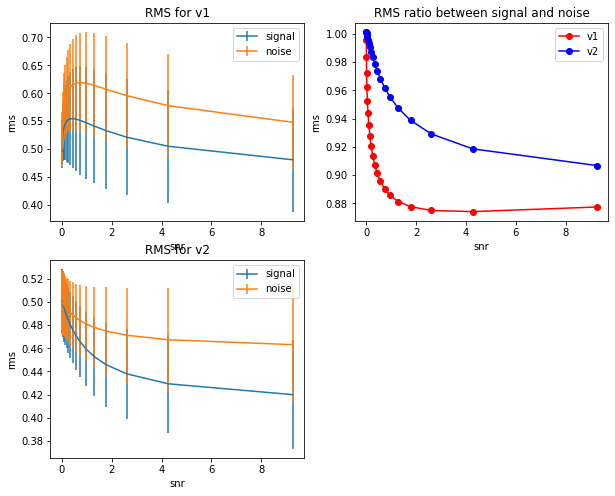

In [13]:
# check the root mean square ratio between signal and noise for different snr
import numpy.linalg as la
rms_1 = {'signal': {'mean': [], 'std': []}, 'noise': {'mean': [], 'std': []}}
rms_2 = {'signal': {'mean': [], 'std': []}, 'noise': {'mean': [], 'std': []}}
aa = np.arange(0, 1, 0.05)
for a in aa:
    # from version 1
    signal_1, label_1 = noisy_sin_signal(f_s=f_s, dur=dur, f_signal=f_sig, sig_dur=sig_dur, 
                                     a=a, seed=22, v1=True)
    X, y = data_matrix(signal_1, label_1, N)
    rms = la.norm(X, axis=1) / np.sqrt(X.shape[1])
    rms_1['signal']['mean'].append(np.mean(rms[y==1]))
    rms_1['signal']['std'].append(np.std(rms[y==1]))
    
    rms_1['noise']['mean'].append(np.mean(rms[y==0]))
    rms_1['noise']['std'].append(np.std(rms[y==0]))
    
    # from version 2
    signal_2, label_2 = noisy_sin_signal(f_s=f_s, dur=dur, f_signal=f_sig, sig_dur=sig_dur, 
                                     a=a, seed=22, v1=False)
    X, y = data_matrix(signal_2, label_2, N)
    rms = la.norm(X, axis=1) / np.sqrt(X.shape[1])
    rms_2['signal']['mean'].append(np.mean(rms[y==1]))
    rms_2['signal']['std'].append(np.std(rms[y==1]))
    
    rms_2['noise']['mean'].append(np.mean(rms[y==0]))
    rms_2['noise']['std'].append(np.std(rms[y==0]))


snr = (aa / np.sqrt(1 - aa ** 2)) ** 2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(221)
plt.title('RMS for v1')
plt.errorbar(snr, rms_1['signal']['mean'], yerr=rms_1['signal']['std'], label='signal')
plt.errorbar(snr, rms_1['noise']['mean'], yerr=rms_1['noise']['std'], label='noise')
plt.xlabel('snr')
plt.ylabel('rms')
plt.legend()

ax = fig.add_subplot(222)
plt.title('RMS ratio between signal and noise')
plt.plot(snr, np.array(rms_1['signal']['mean']) / np.array(rms_1['noise']['mean']), 'ro-', label='v1')
plt.plot(snr, np.array(rms_2['signal']['mean']) / np.array(rms_2['noise']['mean']), 'bo-', label='v2')
plt.xlabel('snr')
plt.ylabel('rms')
plt.legend()

ax = fig.add_subplot(223)
plt.title('RMS for v2')
plt.errorbar(snr, rms_2['signal']['mean'], yerr=rms_2['signal']['std'], label='signal')
plt.errorbar(snr, rms_2['noise']['mean'], yerr=rms_2['noise']['std'], label='noise')
plt.xlabel('snr')
plt.ylabel('rms')
plt.legend()

plt.savefig('figs/rms_ratio.png')

__Comment__: Using the new method where $noise := N(0, a/2) + N(0, \sigma/2)$ instead of $noise := N(0, a/2 + \sigma/2) $ gives a matching RMS between signal and the noise portions.

In [11]:
# check if signal is linearly separable
err = []
for i in range(5):
    signal, label = noisy_sin_signal(f_s=f_s, dur=dur, f_signal=f_sig, sig_dur=sig_dur, a=0.9, 
                                     seed=np.random.randint(100), v1=False)
    X, y = data_matrix(signal, label, N)

    idx = int(len(X) * 2 / 3)
    X_train, y_train = X[:idx], y[:idx]
    X_test, y_test = X[idx:], y[idx:]

    # classifier
    s = np.random.seed(1000)
    l_clf = RFClassifier(width=10, weights=None, nonlinearity=lambda x: x, weight_fun=None, seed=s)
    l_clf.fit(X_train, y_train)
    err.append(1 - l_clf.score(X_test, y_test))
print(np.mean(err))

/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bpandey/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.4400362866646508


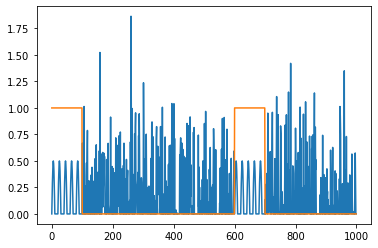

In [62]:
plt.plot((relu(signal[:1000])))
plt.plot(label[:1000])

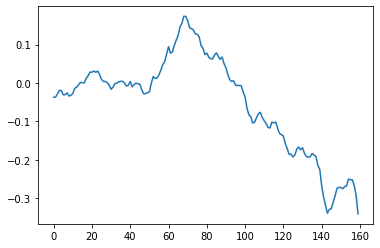

In [11]:
plt.plot(l_clf.clf.coef_.T)